<a href="https://colab.research.google.com/github/VincentK1991/Deep_Learning_Misc/blob/master/imbalanced_classification/Imbalanced_Classification_with_Weighted_Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Packages

In [1]:
%cd '/content/drive/My Drive/Colab Notebooks/Pymc3/Pyro/fraud_detection'

/content/drive/My Drive/Colab Notebooks/Pymc3/Pyro/fraud_detection


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import timeit
from sklearn.preprocessing import scale
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0)) #hopefully we get Tesla P100 
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


# Get dataset

The dataset you can download from https://www.kaggle.com/mlg-ulb/creditcardfraud

- we will transform the data through sigmoid function.

- build a dataloader with batch size = 4096

In [3]:
fraud_data = pd.read_csv('fraud_data.csv')
fraud_data['Amount'] = scale(fraud_data['Amount'])

In [4]:
list_columns = list(fraud_data.columns[1:-1])
X_train, X_val, y_train, y_val = train_test_split(fraud_data[list_columns].values,fraud_data['Class'].values , test_size=0.2, random_state=42)
tensor_X_train = torch.tensor(X_train.astype(np.float32))
tensor_X_val = torch.tensor(X_val.astype(np.float32))
tensor_y_train = torch.tensor(y_train.astype(np.float32))
tensor_y_val = torch.tensor(y_val.astype(np.float32))
tensor_X_train = torch.sigmoid(tensor_X_train)
tensor_X_val = torch.sigmoid(tensor_X_val)

In [6]:
train_data = TensorDataset(tensor_X_train,tensor_y_train)
val_data = TensorDataset(tensor_X_val,tensor_y_val)

train_dataloader = DataLoader(train_data,batch_size=4096,shuffle=True)
val_dataloader = DataLoader(val_data,batch_size=4096,shuffle=True)

# Write helper function

- train batch
- validate batch
- measuring scores

In [7]:
def score_metrices(predict,ground):
  """
  precision = true pos/(true pos + false pos) = true pos/(total predicted pos)
  recall = true pos/(true pos + false neg) = true pos/(total actual pos)
  F1 =   2*(precision*recall)/(precision + recall)

  TODO: handle divide by 0 (in case actual positive class = 0)
  """
  predict = predict.detach().cpu().numpy()
  ground = ground.detach().cpu().numpy()
  predict = predict.astype(int)
  ground = ground.astype(int)

  true_pos = float(np.sum(np.where((predict == ground) & (ground == 1),1,0)))
  total_predicted_pos = np.sum(predict)
  #print('predicted positive', total_predicted_pos)
  precision = true_pos/(total_predicted_pos + 1e-8)

  total_actual_pos = np.sum(ground)
  #print('actual positive ', total_actual_pos)
  recall = true_pos/(total_actual_pos + 1e-8)
  F1 = 2*(precision*recall)/(precision + recall + 1e-8)
  return precision, recall, F1

In [8]:
weight_class_0 = 0.001727486
weight_class_1 = 0.998272514

In [9]:
def train(batch):
  optimizer.zero_grad()
  x,y = batch
  x,y = x.to(device), y.to(device)
  y = y.unsqueeze(1)
  predict = classifier(x)
  predict = torch.nn.functional.softmax(predict,dim=0)
  #x,y = x.cpu(), y.cpu()
  weights = torch.where(y ==0,torch.tensor(weight_class_0).to(device),torch.tensor(weight_class_1).to(device))
  weights = weights.squeeze(1)

  y = y.squeeze(1)

  loss = criterion(predict,y.type(torch.long))
  weighted_loss = loss * weights
  weighted_loss = torch.mean(weighted_loss)

  weighted_loss.backward()
  optimizer.step()
  predict_class = torch.argmax(predict,dim=1)
  #print(predict_class)
  batch_precision, batch_recall, batch_F1 = score_metrices(predict_class,y)

  return weighted_loss, batch_precision, batch_recall, batch_F1

def validate(batch):
  x,y = batch
  x,y = x.to(device), y.to(device)
  y = y.unsqueeze(1)
  weights = torch.where(y ==0,torch.tensor(weight_class_0).to(device),torch.tensor(weight_class_1).to(device))
  weights = weights.squeeze(1)

  predict = classifier(x)
  predict = torch.nn.functional.softmax(predict,dim=0)

  y = y.squeeze(1)
  loss = criterion(predict,y.type(torch.long))
  weighted_loss = loss * weights
  weighted_loss = torch.mean(weighted_loss)
  predict_class = torch.argmax(predict,dim=1)
  batch_precision, batch_recall, batch_F1 = score_metrices(predict_class,y)

  return weighted_loss, batch_precision, batch_recall, batch_F1

In [10]:
def run_train_val(epochs,print_every=1):
  temp_dict = {'train_epoch_loss':[],'val_epoch_loss':[],'train_iter_loss':[],'val_iter_loss':[],
            'train_epoch_precision':[],'val_epoch_precision':[],'train_iter_precision':[],'val_iter_precision':[],
            'train_epoch_recall':[],'val_epoch_recall':[],'train_iter_recall':[],'val_iter_recall':[],
            'train_epoch_F1':[],'val_epoch_F1':[],'train_iter_F1':[],'val_iter_F1':[]}
  epoch_train_loss = []
  epoch_val_loss = []
  
  start = timeit.default_timer()
  for epoch in range(epochs):
    classifier.train()
    temp_train_loss = []
    temp_train_precision = []
    temp_train_recall = []
    temp_train_F1 = []
    for batch in train_dataloader:
      loss, batch_precision, batch_recall, batch_F1 = train(batch)
      temp_train_loss.append(loss.item())
      temp_train_precision.append(batch_precision)
      temp_train_recall.append(batch_recall)
      temp_train_F1.append(batch_F1)
      temp_dict['train_iter_loss'].append(loss.item())
      temp_dict['train_iter_precision'].append(batch_precision)
      temp_dict['train_iter_recall'].append(batch_recall)
      temp_dict['train_iter_F1'].append(batch_F1)
    temp_dict['train_epoch_loss'].append(np.mean(temp_train_loss))
    temp_dict['train_epoch_precision'].append(np.mean(temp_train_precision))
    temp_dict['train_epoch_recall'].append(np.mean(temp_train_recall))
    temp_dict['train_epoch_F1'].append(np.mean(temp_train_F1))

    if epoch % print_every == 0:
      classifier.eval()
      temp_val_loss = []
      temp_val_precision = []
      temp_val_recall = []
      temp_val_F1 = []
      with torch.no_grad():
        for batch in val_dataloader:
          loss, batch_precision, batch_recall, batch_F1 = validate(batch)
          temp_val_loss.append(loss.item())
          temp_val_precision.append(batch_precision)
          temp_val_recall.append(batch_recall)
          temp_val_F1.append(batch_F1)
          temp_dict['val_iter_loss'].append(loss.item())
          temp_dict['val_iter_precision'].append(batch_precision)
          temp_dict['val_iter_recall'].append(batch_recall)
          temp_dict['val_iter_F1'].append(batch_F1)
      scheduler.step(loss)
      temp_dict['val_epoch_loss'].append(np.mean(temp_val_loss))
      temp_dict['val_epoch_precision'].append(np.mean(temp_val_precision))
      temp_dict['val_epoch_recall'].append(np.mean(temp_val_recall))
      temp_dict['val_epoch_F1'].append(np.mean(temp_val_F1))         
      stop = timeit.default_timer()
      print('epoch: {}.. took {}'.format(epoch,stop-start))
      print(' ')
      print('..train loss: {:.3f}  val loss {:.3f}..'.format(temp_dict['train_epoch_loss'][-1],temp_dict['val_epoch_loss'][-1]))
      print('..train precision: {:.3f}  val precision {:.3f}..'.format(temp_dict['train_epoch_precision'][-1],temp_dict['val_epoch_precision'][-1]))
      print('..train recall: {:.3f}  val recall {:.3f}..'.format(temp_dict['train_epoch_recall'][-1],temp_dict['val_epoch_recall'][-1]))
      print('..train F1: {:.3f}  val F1 {:.3f}..'.format(temp_dict['train_epoch_F1'][-1],temp_dict['val_epoch_F1'][-1]))
      print('-----------------------')
      start = timeit.default_timer()
  return temp_dict

# Define the neural net model

In [11]:
class MLP(torch.nn.Module):
  def __init__(self,input_size,hidden_size1,hidden_size2,hidden_size3,dropout1,dropout2,dropout3):
    super(MLP,self).__init__()
    self.input_size = input_size
    self.hidden_size1 = hidden_size1
    self.hidden_size2 = hidden_size2
    self.hidden_size3 = hidden_size3
    self.dropout1 = nn.Dropout(dropout1)
    self.dropout2 = nn.Dropout(dropout2)
    self.dropout3 = nn.Dropout(dropout3)
    
    self.relu = torch.nn.ReLU()

    self.fc1 = torch.nn.Linear(self.input_size,self.hidden_size1)
    self.fc2 = torch.nn.Linear(self.hidden_size1,self.hidden_size2)
    self.fc3 = torch.nn.Linear(self.hidden_size2,self.hidden_size3)
    self.fc4 = torch.nn.Linear(self.hidden_size3,2)

  def forward(self,x):
    x = self.dropout1(self.relu(self.fc1(x)))
    x = self.dropout2(self.relu(self.fc2(x)))
    x = self.dropout3(self.relu(self.fc3(x)))
    output = self.fc4(x)
    return output

# Train-validation

In [12]:
classifier = MLP(input_size = 29,hidden_size1=64,hidden_size2=32,hidden_size3=16,dropout1=0.4,dropout2=0.3,dropout3=0.2)
learning_rate = 1e-3
weight_decay = 0
classifier = classifier.to(device)
criterion = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.75,patience=10,cooldown=20,verbose=True)

In [13]:
temp_dict = run_train_val(200,print_every=10)

epoch: 0.. took 2.660421806000045
 
..train loss: 0.002  val loss 0.002..
..train precision: 0.002  val precision 0.003..
..train recall: 0.607  val recall 0.980..
..train F1: 0.004  val F1 0.007..
-----------------------
epoch: 10.. took 20.237901423999915
 
..train loss: 0.002  val loss 0.002..
..train precision: 0.008  val precision 0.778..
..train recall: 0.839  val recall 0.879..
..train F1: 0.017  val F1 0.798..
-----------------------
epoch: 20.. took 19.854723913000043
 
..train loss: 0.002  val loss 0.002..
..train precision: 0.030  val precision 0.797..
..train recall: 0.842  val recall 0.855..
..train F1: 0.058  val F1 0.814..
-----------------------
epoch: 30.. took 19.778986145999966
 
..train loss: 0.002  val loss 0.002..
..train precision: 0.053  val precision 0.740..
..train recall: 0.838  val recall 0.865..
..train F1: 0.098  val F1 0.788..
-----------------------
epoch: 40.. took 19.805666768999913
 
..train loss: 0.002  val loss 0.002..
..train precision: 0.179  val 

Text(0.5, 0.98, 'validation scores')

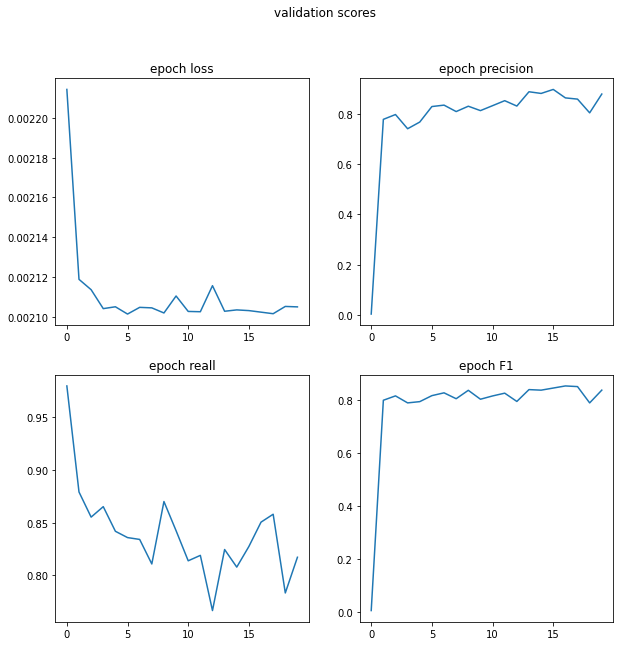

In [14]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
ax[0,0].plot(temp_dict['val_epoch_loss'])
ax[0,0].set_title('epoch loss')
ax[0,1].plot(temp_dict['val_epoch_precision'])
ax[0,1].set_title('epoch precision')
ax[1,0].plot(temp_dict['val_epoch_recall'])
ax[1,0].set_title('epoch reall')
ax[1,1].plot(temp_dict['val_epoch_F1'])
ax[1,1].set_title('epoch F1')
plt.suptitle('validation scores')

In [ ]:
torch.save(classifier.state_dict(), 'credit_card_fraud_classifier.pt')